# Import any and all packages that I've ever used and might be helpful

In [1]:
import pickle 
import numpy as np
from astropy.io import fits
from astropy.convolution import convolve, Box1DKernel
from astropy import modeling
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.idl import readsav
from scipy.signal import find_peaks
import pickle 
from astropy.io import fits
# from spectral_cube import SpectralCube
from astropy import units as u
import numpy.ma as ma
from astropy.stats import sigma_clip
import matplotlib.patheffects as path_effects
from matplotlib.gridspec import GridSpec
import mpl_toolkits.axes_grid1.axes_grid as axes_grid
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#from mpl_toolkits.axes_grid.colorbar import colorbar
from matplotlib.patches import Ellipse
import math
from matplotlib import cm
from astropy.wcs import WCS
import scipy
import scipy.ndimage as ndi
from scipy import optimize
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import pkg_resources
#from specutils import Spectrum1D, SpectralRegion
from astropy.modeling import models
#from specutils.spectra import Spectrum1D
#from specutils.fitting import fit_lines
from __future__ import print_function
#import pyspeckit
import pylab as pl

C:\Users\lucys\AppData\Local\Temp\ipykernel_27212\2141777465.py:8: DeprecationWarning: Please use `readsav` from the `scipy.io` namespace, the `scipy.io.idl` namespace is deprecated.
  from scipy.io.idl import readsav


# Open the Data Cube and see what is even happening

In [2]:
source = '2345-167'
line = 'HCN'
path = source + '_' + line + '.pbcor.fits'

cube = fits.open(path)
data = cube[0].data
print("Shape of Array:")
print(data.shape)
header = cube[0].header

Shape of Array:
(1, 1918, 300, 300)


In [29]:
print(header)

SIMPLE  =                    T /Standard FITS                                   BITPIX  =                  -32 /Floating point (32 bit)                         NAXIS   =                    4                                                  NAXIS1  =                  300                                                  NAXIS2  =                  300                                                  NAXIS3  =                 1918                                                  NAXIS4  =                    1                                                  EXTEND  =                    T                                                  BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 BZERO   =   0.000000000000E+00                                                  BMAJ    =   8.197426088217E-04                                                  BMIN    =   5.282115788434E-04                                                  BPA     =  -7.595690788679E+01          

In [4]:
print('Axis 1 is {:8s}'.format(header["CTYPE1"]))
print('Axis 2 is {:8s}'.format(header["CTYPE2"]))
print('Axis 3 is {:8s}'.format(header["CTYPE3"]))
print('Axis 4 is {:8s}'.format(header["CTYPE4"]))
print('Rest Frequncy: ', header['RESTFRQ']/1E+9, 'GHz')

Axis 1 is RA---SIN
Axis 2 is DEC--SIN
Axis 3 is FREQ    
Axis 4 is STOKES  
Rest Frequncy:  88.631601 GHz


# Finding the location of the brightest pixel in each of the background images

In [8]:
from astropy import units as u
from astropy.coordinates import SkyCoord

path = '2345-167_HCOp.pbcor.fits'
cube = fits.open(path)
data = cube[0].data
print(data.shape)
header = cube[0].header

image = np.squeeze(data)
print(image.shape)

integrated = np.sum(image[:, :, :], axis = 0)
max_val = np.nanmax(integrated)
x, y = np.where(integrated == np.nanmax(integrated))

ra_start = header["CRVAL1"]
ra_inc = header["CDELT1"]

channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

ra = ra_start + (ra_inc * channels)
ra = np.array(ra, dtype = float)

dec_start = header["CRVAL2"]
dec_inc = header["CDELT2"]

channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

dec = dec_start + (dec_inc * channels1)
dec = np.array(dec, dtype = float)

print(ra[x], dec[y])

#c_icrs = SkyCoord(ra=ra[x]*u.degree, dec=dec[y]*u.degree, frame='icrs')
#c_icrs.galactic

(1, 1918, 300, 300)
(1918, 300, 300)
[357.01086333] [-16.52000167]


In [10]:
points = np.where(image>0.9*np.nanmax(image))
print(points)

invalid value encountered in greater


(array([   0,    0,    0, ..., 1917, 1917, 1917], dtype=int64), array([188, 188, 189, ..., 189, 189, 189], dtype=int64), array([189, 190, 188, ..., 188, 189, 190], dtype=int64))


# Plotting Spectra (increasing the number of pixels) (smoothing over 15 pixels)

In [11]:
def plot_spectra(source = 'NGC3783'):
    
    #Open the cube (This is the background source image, not the acutal cube)
    #I'm using that to take the spectrum at where it should theorhetically be the brightest
    #path = source + '_HCO.image.fits'
    path = source + '.pbcor.fits'
    cube = fits.open(path)
    data = cube[0].data
    header = cube[0].header

    #Define the figure size
    plt.figure(figsize=[10,8])

    #Define coordinate system in terms of RA and DEC
    ra_start = header["CRVAL1"]
    ra_inc = header["CDELT1"]

    channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

    ra = ra_start + (ra_inc * channels)
    ra = np.array(ra, dtype = float)

    dec_start = header["CRVAL2"]
    dec_inc = header["CDELT2"]

    channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

    dec = dec_start + (dec_inc * channels1)
    dec = np.array(dec, dtype = float)

    #Converting from Frequeny to Velocity
    frequency_start = header["CRVAL3"]
    frequency_inc = header["CDELT3"]

    channels2 = np.arange(header["NAXIS3"])

    frequency = frequency_start + (frequency_inc * channels2)
    #frequency = np.array(frequency, dtype = float)

    i_frequency = header["RESTFRQ"]
    velocity = (3E8*((i_frequency-frequency)/i_frequency))/1000
    velocity = np.array(velocity, dtype = float)
    
    path1= source + '.pbcor.fits'
    cube1=fits.open(path1)
    data1=cube1[0].data
    print(data.shape)

    data2 = np.squeeze(data1)
    print(data2.shape)
    
    #Looking through this, it might make more sense to define the box in terms of the pixel and then make a box of a certain
    #number of pixels on in either direction, rather than picking arbitrary points to define the edges of the box
    #I'm using a box of 15 pixels around the central coordinate so it is a square of 30 pixels on each side
    if source == 'NGC7714': 
        x1 = round(header["CRPIX1"]-(ra_start-354.058992)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start-2.155161)/dec_inc)-1
    elif source == 'NGC7469':
        x1 = round(header["CRPIX1"]-(ra_start-345.815207)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start-8.874053)/dec_inc)-1
    elif source == '2331p073':
        x1 = round(header["CRPIX1"]-(ra_start-353.553394)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start-7.607653)/dec_inc)-1
    elif source == 'NGC3783':
        x1 = round(header["CRPIX1"]-(ra_start-174.757286)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+37.7385028)/dec_inc)-1
    elif source == '0208-512':
        x1 = round(header["CRPIX1"]-(ra_start-32.6925)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+51.01719444444)/dec_inc)-1
    elif source == 'J0635-7516':
        x1 = round(header["CRPIX1"]-(ra_start-98.943783)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+75.271337)/dec_inc)-1
    elif source == '2355-534':
        x1 = round(header["CRPIX1"]-(ra_start-359.471942)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+53.187136)/dec_inc)-1
    elif source == '2326-477':
        x1 = round(header["CRPIX1"]-(ra_start-352.323767)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+47.505308)/dec_inc)-1
    elif source == 'J1058-8003':
        x1 = round(header["CRPIX1"]-(ra_start-164.680290)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+80.065208)/dec_inc)-1
    elif source == 'J0454-8101':
        x1 = round(header["CRPIX1"]-(ra_start-72.522612)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+81.017342)/dec_inc)-1
    elif source == 'J0253-5441':
        x1 = round(header["CRPIX1"]-(ra_start-43.371585)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+54.69762111111)/dec_inc)-1
    elif source == '2345-167':
        x1 = round(header["CRPIX1"]-(ra_start-357.010867)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+16.520006)/dec_inc)-1
        
    box = 15
    
    data3 = data2[:, np.arange(x1-box, x1+box)]
    image = data3[np.arange(y1-box, y1+box), :]

    maxindex = np.unravel_index(image.argmax(), image.shape)
    
    spec_1_cont = image[maxindex]
    
    points = np.where(image>0.99*np.nanmax(image))
    
    sum_tot=0
    sum_spect=0
    sum_wts=0
    for i in range(len(points[0])):
        spectrum = (np.squeeze(data[0,:,points[0][i],points[1][i]])/spec_1_cont*image[points[0][i],points[1][i]] + image[points[0][i],points[1][i]])/image[points[0][i],points[1][i]]
        sum_tot = spectrum + sum_tot
        sum_spect = sum_spect + spectrum * image[points[0][i],points[1][i]]**2
        sum_wts = sum_wts + image[points[0][i],points[1][i]]**2
    smoothing_15 = convolve(sum_spect, Box1DKernel(15))
    smoothed_decimated_spect = smoothing_15[::15]
    spect = smoothed_decimated_spect[1:]
    decimated_xvals = velocity[::15]
    x = decimated_xvals[1:]
    decimated_yvals = spect/(sum_wts+spec_1_cont)
    plt.plot(x, decimated_yvals, label='Weighted Average 99%')
    
    points = np.where(image>0.9*np.nanmax(image))
    
    sum_tot=0
    sum_spect=0
    sum_wts=0
    for i in range(len(points[0])):
        spectrum = (np.squeeze(data[0,:,points[0][i],points[1][i]])/spec_1_cont*image[points[0][i],points[1][i]] + image[points[0][i],points[1][i]])/image[points[0][i],points[1][i]]
        sum_tot = spectrum + sum_tot
        sum_spect = sum_spect + spectrum * image[points[0][i],points[1][i]]**2
        sum_wts = sum_wts + image[points[0][i],points[1][i]]**2
    smoothing_15 = convolve(sum_spect, Box1DKernel(15))
    smoothed_decimated_spect = smoothing_15[::15]
    spect = smoothed_decimated_spect[1:]
    decimated_xvals = velocity[::15]
    x = decimated_xvals[1:]
    decimated_yvals = spect/(sum_wts+spec_1_cont)
    plt.plot(x, decimated_yvals, label='Weighted Average 90%')
    
    points = np.where(image>0.75*np.nanmax(image))
    
    sum_tot=0
    sum_spect=0
    sum_wts=0
    for i in range(len(points[0])):
        spectrum = (np.squeeze(data[0,:,points[0][i],points[1][i]])/spec_1_cont*image[points[0][i],points[1][i]] + image[points[0][i],points[1][i]])/image[points[0][i],points[1][i]]
        sum_tot = spectrum + sum_tot
        sum_spect = sum_spect + spectrum * image[points[0][i],points[1][i]]**2
        sum_wts = sum_wts + image[points[0][i],points[1][i]]**2
    smoothing_15 = convolve(sum_spect, Box1DKernel(15))
    smoothed_decimated_spect = smoothing_15[::15]
    spect = smoothed_decimated_spect[1:]
    decimated_xvals = velocity[::15]
    x = decimated_xvals[1:]
    decimated_yvals = spect/(sum_wts+spec_1_cont)
    plt.plot(x, decimated_yvals, label='Weighted Average 75%')
    
    points = np.where(image>0.5*np.nanmax(image))
    
    sum_tot=0
    sum_spect=0
    sum_wts=0
    for i in range(len(points[0])):
        spectrum = (np.squeeze(data[0,:,points[0][i],points[1][i]])/spec_1_cont*image[points[0][i],points[1][i]] + image[points[0][i],points[1][i]])/image[points[0][i],points[1][i]]
        sum_tot = spectrum + sum_tot
        sum_spect = sum_spect + spectrum * image[points[0][i],points[1][i]]**2
        sum_wts = sum_wts + image[points[0][i],points[1][i]]**2
    smoothing_15 = convolve(sum_spect, Box1DKernel(15))
    smoothed_decimated_spect = smoothing_15[::15]
    spect = smoothed_decimated_spect[1:]
    decimated_xvals = velocity[::15]
    x = decimated_xvals[1:]
    decimated_yvals = spect/(sum_wts+spec_1_cont)
    plt.plot(x, decimated_yvals, label='Weighted Average 50%')

    plt.xlabel('Velocity (km/s)')
    plt.ylabel('HCO+ Absorption')
    plt.title('HCO+ Absorption Spectrum at '+ source, fontsize=16)
    plt.legend()
    plt.grid()
    
    #plt.savefig(source + '_Absorption_Spectra.png')

In [12]:
plot_spectra(source = '2345-167')

FileNotFoundError: [Errno 2] No such file or directory: '2345-167.pbcor.fits'

In [68]:
#This takes the integrated intensity right around the background source so we can look at it more easily

source  = 'J1058-8003'
path = source + '_HCOp.pbcor.fits'
cube = fits.open(path)
data = cube[0].data
header = cube[0].header

squeezed_data = np.squeeze(data)

plt.figure(figsize=[6,6])

ra_start = header["CRVAL1"]
ra_inc = header["CDELT1"]

channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

ra = ra_start + (ra_inc * channels)
ra = np.array(ra, dtype = float)

print(ra[224])

dec_start = header["CRVAL2"]
dec_inc = header["CDELT2"]

channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

dec = dec_start + (dec_inc * channels1)
dec = np.array(dec, dtype = float)

print(dec[227])

#if source == 'NGC7714': 
    #x1 = round(header["CRPIX1"]-(ra_start-354.058992)/ra_inc)-1
    #y1 = round(header["CRPIX2"]-(dec_start-2.155161)/dec_inc)-1
#elif source == 'NGC7469':
    #x1 = round(header["CRPIX1"]-(ra_start-345.815207)/ra_inc)-1
    #y1 = round(header["CRPIX2"]-(dec_start-8.874053)/dec_inc)-1

#box = 50
#xa = x1 - box
#xb = x1 + box
#ya = y1 - box
#yb = y1 + box

#data2 = squeezed_data[:, :, np.arange(xa, xb)]
#data3 = data2[:, np.arange(ya, yb), :]

#integrated = np.sum(data3[:, :, :], axis = 0)

#extent=[ra[xa],ra[xb],dec[ya],dec[yb]]

#max_val = np.nanmax(integrated)
#print(np.where(integrated == np.nanmax(integrated)))

#plt.imshow(integrated, origin= 'lower', extent=extent)

#plt.xticks()
#plt.yticks()
#plt.xlabel('RA (deg)',fontsize=12)
#plt.ylabel('DEC (deg)',fontsize=12)
#plt.colorbar( fraction=0.04, pad=0.04, label = 'Integrated Intensity')
#plt.title(source + ' Integrated Intensity', fontsize= 14)

source  = 'J0635-7516'
path = source + '_HCOp.pbcor.fits'
cube = fits.open(path)
data = cube[0].data
header = cube[0].header

squeezed_data = np.squeeze(data)

plt.figure(figsize=[6,6])

ra_start = header["CRVAL1"]
ra_inc = header["CDELT1"]

channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

ra = ra_start + (ra_inc * channels)
ra = np.array(ra, dtype = float)

print(ra[189])

dec_start = header["CRVAL2"]
dec_inc = header["CDELT2"]

channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

dec = dec_start + (dec_inc * channels1)
dec = np.array(dec, dtype = float)

print(dec[189])

#if source == 'NGC7714': 
    #x1 = round(header["CRPIX1"]-(ra_start-354.058992)/ra_inc)-1
    #y1 = round(header["CRPIX2"]-(dec_start-2.155161)/dec_inc)-1
#elif source == 'NGC7469':
    #x1 = round(header["CRPIX1"]-(ra_start-345.815207)/ra_inc)-1
    #y1 = round(header["CRPIX2"]-(dec_start-8.874053)/dec_inc)-1
#elif source == '2345-167':
    #x1 = round(header["CRPIX1"]-(ra_start-357.0108633333)/ra_inc)-1
    #y1 = round(header["CRPIX2"]-(dec_start+16.52000166667)/dec_inc)-1

#xa = x1 - box
#xb = x1 + box
#ya = y1 - box
#yb = y1 + box

#data2 = squeezed_data[:, :, np.arange(xa, xb)]
#data3 = data2[:, np.arange(ya, yb), :]

#integrated = np.sum(data3[:, :, :], axis = 0)

#extent=[ra[xa],ra[xb],dec[ya],dec[yb]]

#max_val = np.nanmax(integrated)
#print(np.where(integrated == np.nanmax(integrated)))

#plt.imshow(integrated, origin= 'lower', extent=extent)

#plt.xticks()
#plt.yticks()
#plt.xlabel('RA (deg)',fontsize=12)
#plt.ylabel('DEC (deg)',fontsize=12)
#plt.colorbar( fraction=0.04, pad=0.04, label = 'Integrated Intensity')
#plt.title(source + ' Integrated Intensity', fontsize= 14)

164.6804358333
-80.06500388888666
98.94376041667
-75.27133638889


<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

# Taking the Flux Density Spectrum at just the brightest pixel

In [114]:
def flux_density_spectra(source = 'NGC3783', line = 'HCOp'):
    
    #Open the cube (This is not the background source image, it is the acutal cube)
    #We don't need the background source image anymore so I'm going to be editing the code to take that into account.
    path = source + '_' + line + '.pbcor.fits'
    cube = fits.open(path)
    data = cube[0].data
    header = cube[0].header
    
    squeezed_data = np.squeeze(data)
    #print(squeezed_data.shape)

    #Define the figure size
    plt.figure(figsize=[10,8])

    #Define coordinate system in terms of RA and DEC for the cube
    ra_start = header["CRVAL1"]
    ra_inc = header["CDELT1"]

    channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

    ra = ra_start + (ra_inc * channels)
    ra = np.array(ra, dtype = float)

    dec_start = header["CRVAL2"]
    dec_inc = header["CDELT2"]

    channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

    dec = dec_start + (dec_inc * channels1)
    dec = np.array(dec, dtype = float)

    #Converting from Frequeny to Velocity
    frequency_start = header["CRVAL3"]
    frequency_inc = header["CDELT3"]

    channels2 = np.arange(header["NAXIS3"])

    frequency = frequency_start + (frequency_inc * channels2)
    #frequency = np.array(frequency, dtype = float)

    i_frequency = header["RESTFRQ"]
    velocity = (3E8*((i_frequency - frequency)/i_frequency))/1000
    velocity = np.array(velocity, dtype = float)
    print(velocity[0], velocity[-1])
    
    #Looking through this, it might make more sense to define the box in terms of the pixel and then make a box of a certain
    #number of pixels on in either direction, rather than picking arbitrary points to define the edges of the box
    #I'm using a box of 2 pixels around the central coordinate so it is a square of 5 pixels on each side
    
    if source == 'NGC7714':
        if line == 'HCOp':
            x1 = round(header["CRPIX1"]-(ra_start-354.058992)/ra_inc)-1
            y1 = round(header["CRPIX2"]-(dec_start-2.155161)/dec_inc)-1
    elif source == 'NGC7469':
        if line == 'HCOp':
            x1 = round(header["CRPIX1"]-(ra_start-345.815207)/ra_inc)-1
            y1 = round(header["CRPIX2"]-(dec_start-8.874053)/dec_inc)-1
    elif source == '2331p073':
        x1 = round(header["CRPIX1"]-(ra_start-353.5534454167)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start-7.60773555555577)/dec_inc)-1
    elif source == 'NGC3783':
        x1 = round(header["CRPIX1"]-(ra_start-174.757286)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+37.7385028)/dec_inc)-1
    elif source == '0208-512':
        x1 = round(header["CRPIX1"]-(ra_start-32.6925)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+51.01719444444)/dec_inc)-1
    elif source == 'J0635-7516':
        x1 = round(header["CRPIX1"]-(ra_start-98.94376041667)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+75.27133638889)/dec_inc)-1
    elif source == '2355-534':
        x1 = round(header["CRPIX1"]-(ra_start-359.47194)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+53.18713138889)/dec_inc)-1
    elif source == '2326-477':
        x1 = round(header["CRPIX1"]-(ra_start-352.323767)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+47.505308)/dec_inc)-1
    elif source == 'J1058-8003':
        x1 = round(header["CRPIX1"]-(ra_start-164.6804358333)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+80.0650038888866)/dec_inc)-1
    elif source == 'J0454-8101':
        x1 = round(header["CRPIX1"]-(ra_start-72.5227836111144)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+81.0172111111077)/dec_inc)-1
    elif source == 'J0253-5441':
        x1 = round(header["CRPIX1"]-(ra_start-43.371585)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+54.69762111111)/dec_inc)-1
    elif source == '2345-167':
        x1 = round(header["CRPIX1"]-(ra_start-357.0108633333)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+16.52000166667)/dec_inc)-1
    elif source == 'J2230+114':
        x1 = round(header["CRPIX1"]-(ra_start-338.1516991667)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start-11.73081027778)/dec_inc)-1
    elif source == 'J0049-4457':
        x1 = round(header["CRPIX1"]-(ra_start-12.31926375)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+44.95309611111)/dec_inc)-1
        
    spectrum = squeezed_data[:, y1, x1]
    
    #Smooth over 20 channels to get a resolution over 2 km/s
    smoothing_20 = convolve(spectrum, Box1DKernel(25))
    smoothed_decimated_spect = smoothing_20[::25]
    spect = smoothed_decimated_spect[1:]
    decimated_xvals = velocity[::25]
    x = decimated_xvals[1:]
    
    #print(np.where(velocity == 350))
    
    #array = np.arange(1100, 1200, 1)
    #plt.plot(velocity[array],spectrum[array], label = 'Spectrum at Brightest Pixel')
    #plt.plot(x,spect, label = 'Spectrum at Brightest Pixel')
    #plt.vlines(x = 361.5, ymin = 1.375, ymax = 1.525, linestyles = 'dashed')
    
    #polyfit = np.polyfit(x, spect, deg = 6)
    
    #p = np.poly1d(polyfit)
    #xp = np.linspace(x[0], x[-1], 1000)
    
    #print(np.mean(spectrum))
    
    #plt.plot(velocity, spectrum)

    #plt.xlabel('Velocity (km/s)')
    #plt.ylabel('Flux Density (Jy)')
    #plt.title('Flux Density Spectrum at '+ source + ' for ' + line, fontsize=16)
    #plt.legend()
    #plt.grid()
    
    #plt.savefig(source + line + '_Flux_Density.png')

In [115]:
flux_density_spectra(source = '2331p073', line = 'CCH')
flux_density_spectra(source = 'J0635-7516', line = 'CCH')
flux_density_spectra(source = '2355-534', line = 'CCH')
flux_density_spectra(source = 'J1058-8003', line = 'CCH')
flux_density_spectra(source = 'J0454-8101', line = 'CCH')
flux_density_spectra(source = 'J2230+114', line = 'CCH')
flux_density_spectra(source = '2345-167', line = 'CCH')
flux_density_spectra(source = 'J0049-4457', line = 'CCH')

-435.6542772396869 -234.66718770749642
140.6197104482739 341.6301101018997
118.25564915283445 319.25104137437074
279.81453055055965 480.82168084514694
152.87771026863135 353.883673158191
-421.77813788115463 -220.79452333007524
-286.3690617708468 -85.37602626929937
-27.86172413042604 173.13813229161798


<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

# GALFA Survey HI Comparison

In [8]:
def galfa_hi(source = 'NGC7714', molecule = 'HCN'):
    
    path = source + '_' + molecule + '.pbcor.fits'
    cube = fits.open(path)
    data = cube[0].data
    header = cube[0].header
    
    squeezed_data = squeezed_data = np.squeeze(data)

    #Define the figure size
    plt.figure(figsize=[10,8])

    #Define coordinate system in terms of RA and DEC for the cube
    ra_start = header["CRVAL1"]
    ra_inc = header["CDELT1"]

    channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

    ra = ra_start + (ra_inc * channels)
    ra = np.array(ra, dtype = float)

    dec_start = header["CRVAL2"]
    dec_inc = header["CDELT2"]

    channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

    dec = dec_start + (dec_inc * channels1)
    dec = np.array(dec, dtype = float)

    #Converting from Frequeny to Velocity
    frequency_start = header["CRVAL3"]
    frequency_inc = header["CDELT3"]

    channels2 = np.arange(header["NAXIS3"])

    frequency = frequency_start + (frequency_inc * channels2)
    #print(frequency[150])
    #frequency = np.array(frequency, dtype = float)

    i_frequency = header["RESTFRQ"]
    velocity = (3E8*((i_frequency - frequency)/i_frequency))/1000
    velocity = np.array(velocity, dtype = float)
    #print(c_velocity[0], c_velocity[-1])
    
    #Looking through this, it might make more sense to define the box in terms of the pixel and then make a box of a certain
    #number of pixels on in either direction, rather than picking arbitrary points to define the edges of the box
    #I'm using a box of 15 pixels around the central coordinate so it is a square of 30 pixels on each side
    if source == 'NGC7714': 
        x1 = round(header["CRPIX1"]-(ra_start-354.058992)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start-2.155161)/dec_inc)-1
    elif source == 'NGC7469':
        x1 = round(header["CRPIX1"]-(ra_start-345.815207)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start-8.874053)/dec_inc)-1
    elif source == '2331p073':
        x1 = round(header["CRPIX1"]-(ra_start-353.5534454167)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start-7.60773555555577)/dec_inc)-1
        
    spectrum = squeezed_data[:, y1, x1]
    
    smoothing_25 = convolve(spectrum, Box1DKernel(25))
    smoothed_decimated_spect = smoothing_25[::25]
    spect = smoothed_decimated_spect[1:]
    decimated_xvals = velocity[::25]
    x = decimated_xvals[1:]
    
    plt.plot(x, spect, label = 'HCO+ Flux Density Spectrum at Brightest Pixel')
    
    #print('mean value =', np.mean(spect))
    std_dev1 = spect - np.mean(spect)
    std_dev2 = std_dev1**2
    std_dev3 = np.sum(std_dev2)
    std_dev4 = std_dev3/len(spect)
    std_dev5 = math.sqrt(std_dev4)
    print('Standard Deviation =', std_dev5)
    
    #I have GALFA data for three sources but the naming conventions are based on the coordinates not the sources because 
    #they are only close by, not actually at that exact spot
    if source == 'NGC7714':
        coord = '356.00+02.35'
    elif source == 'NGC7469':
        coord = '348.00+10.35'
    elif source == '2331p073':
        coord = '356.00+10.35'
    elif source == 'J2230+114':
        coord = '340.00+10.35'
    
    g_path = 'GALFA_HI_RA+DEC_' + coord + '_W.fits'
    g_cube = fits.open(g_path)
    g_data = g_cube[0].data
    g_header = g_cube[0].header
    
    #print(g_data.shape)
    #print(g_header)
    
    g_ra_start = g_header["CRVAL1"]
    g_ra_inc = g_header["CDELT1"]

    g_channels = np.arange(g_header["NAXIS1"]) - g_header["CRPIX1"]+1

    g_ra = g_ra_start + (g_ra_inc * g_channels)
    g_ra = np.array(g_ra, dtype = float)

    g_dec_start = g_header["CRVAL2"]
    g_dec_inc = g_header["CDELT2"]

    g_channels1 = np.arange(g_header["NAXIS2"]) - g_header["CRPIX2"]+1

    g_dec = g_dec_start + (g_dec_inc * g_channels1)
    g_dec = np.array(g_dec, dtype = float)
    
    g_velocity_start = g_header["CRVAL3"]
    g_velocity_inc = g_header["CDELT3"]

    g_channels2 = np.arange(g_header["NAXIS3"])-g_header["CRPIX3"]+1

    g_velocity = g_velocity_start + (g_velocity_inc * g_channels2)
    g_velocity_kms = g_velocity/1000
    #print(g_velocity_kms[0], g_velocity_kms[-1])
    
    #Here we find the corresponding pixels for the brightest point in HCO+ in the GALFA data
    y_array = np.abs(g_dec-dec[y1])
    g_y = y_array.argmin()
    x_array = np.abs(g_ra-ra[x1])
    g_x = x_array.argmin()
    
    #Now we have to find the corresponding velocity channels for HI and HCO+
    g_vel_1 = np.abs(g_velocity_kms - velocity[0])
    g_vel_min = g_vel_1.argmin()
    #print(g_vel_min)
    g_vel_2 = np.abs(g_velocity_kms - velocity[-1])
    g_vel_max = g_vel_2.argmin()
    #print(g_vel_max)
    
    g_vel_chans = np.arange(g_vel_min, g_vel_max, 1)
    #print(g_vel_chans)
    g_vel_kms = g_velocity_kms[g_vel_chans]
    
    g_spectrum = g_data[:, g_y, g_x]
    g_spect = g_spectrum[g_vel_chans]/25
    
    g_smoothing_6 = convolve(g_spect, Box1DKernel(1))
    g_smoothed_decimated_spect = g_smoothing_6[::1]
    g_spectr = g_smoothed_decimated_spect[1:]
    g_decimated_xvals = g_vel_kms[::1]
    g_x_vals = g_decimated_xvals[1:]
    
    plt.plot(g_x_vals, g_spectr + 0.58, label = 'GALFA HI Emission Spectrum')
    
    plt.xlabel('Velocity (km/s)')
    plt.ylabel('HCO+ Absorption')
    plt.title('HCO+ Flux Density Spectrum at '+ source, fontsize=16)
    plt.legend(loc = 1)
    plt.grid()
    
    #plt.savefig('new_' + source + '_HI_Compare.png')

Standard Deviation = 0.003751434371897029


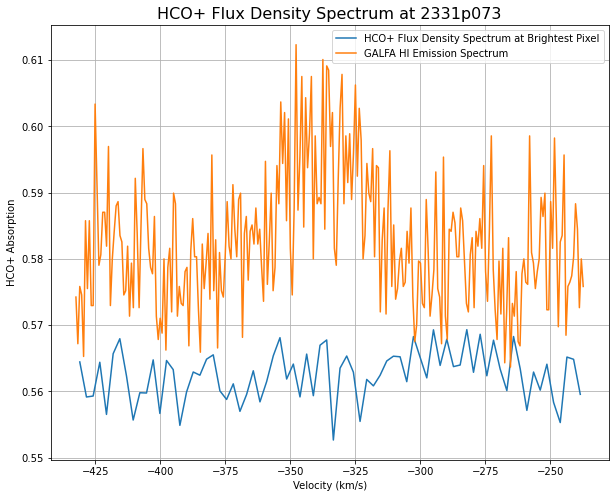

In [9]:
galfa_hi(source = '2331p073', molecule = 'HCOp')

# GASS HI Comparison

In [36]:
def gass_hi(source = 'NGC3783', molecule = 'HCOp'):
    
    path = source + '_' + molecule + '.pbcor.fits'
    cube = fits.open(path)
    data = cube[0].data
    header = cube[0].header
    
    image = np.squeeze(data)

    #Define the figure size
    plt.figure(figsize=[10,8])

    #Define coordinate system in terms of RA and DEC for the cube
    ra_start = header["CRVAL1"]
    ra_inc = header["CDELT1"]

    channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

    ra = ra_start + (ra_inc * channels)
    ra = np.array(ra, dtype = float)
    
    dec_start = header["CRVAL2"]
    dec_inc = header["CDELT2"]

    channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

    dec = dec_start + (dec_inc * channels1)
    dec = np.array(dec, dtype = float)

    #Converting from Frequeny to Velocity
    frequency_start = header["CRVAL3"]
    frequency_inc = header["CDELT3"]

    channels2 = np.arange(header["NAXIS3"])

    frequency = frequency_start + (frequency_inc * channels2)
    #frequency = np.array(frequency, dtype = float)

    i_frequency = header["RESTFRQ"]
    velocity = (3E8*((i_frequency - frequency)/i_frequency))/1000
    velocity = np.array(velocity, dtype = float)
    print(velocity[1]- velocity[0])

    integrated = np.sum(image[:, :, :], axis = 0)
    max_val = np.nanmax(integrated)
    x, y = np.where(integrated == np.nanmax(integrated))
    
    #Defining the brightest pixels
    x1 = round(header["CRPIX1"]-(ra_start-float(ra[x]))/ra_inc)-1
    y1 = round(header["CRPIX2"]-(dec_start-float(dec[y]))/dec_inc)-1
    
    #Take the spectrum at only the pixel where the background is the brightest
    spectrum = image[:, y1, x1]
    
    smoothing_25 = convolve(spectrum, Box1DKernel(25))
    smoothed_decimated_spect = smoothing_25[::25]
    spect = smoothed_decimated_spect[1:]
    decimated_xvals = velocity[::25]
    x = decimated_xvals[1:]
    
    plt.plot(x, spect, label = 'HCO+ Flux Density Spectrum at Brightest Pixel')
    
    print('mean value =', np.mean(spect))
    std_dev1 = spect - np.mean(spect)
    std_dev2 = std_dev1**2
    std_dev3 = np.sum(std_dev2)
    std_dev4 = std_dev3/len(spect)
    std_dev5 = math.sqrt(std_dev4)
    print('Standard Deviation =', std_dev5)
    
    #g_path = source + '_GASS_HI.fits'
    #g_cube = fits.open(g_path)
    #g_data = g_cube[0].data
    #g_header = g_cube[0].header
    
    #print(g_data.shape)
    
    #g_ra_start = g_header["CRVAL1"]
    #g_ra_inc = g_header["CDELT1"]

    #g_channels = np.arange(g_header["NAXIS1"]) - g_header["CRPIX1"]+1

    #g_ra = g_ra_start + (g_ra_inc * g_channels)
    #g_ra = np.array(g_ra, dtype = float)

    #g_dec_start = g_header["CRVAL2"]
    #g_dec_inc = g_header["CDELT2"]

    #g_channels1 = np.arange(g_header["NAXIS2"]) - g_header["CRPIX2"]+1

    #g_dec = g_dec_start + (g_dec_inc * g_channels1)
    #g_dec = np.array(g_dec, dtype = float)
    
    #g_velocity_start = g_header["CRVAL3"]
    #g_velocity_inc = g_header["CDELT3"]

    #g_channels2 = np.arange(g_header["NAXIS3"])-g_header["CRPIX3"]+1

    #g_velocity = g_velocity_start + (g_velocity_inc * g_channels2)
    #g_velocity_kms = g_velocity/1000
    #print(g_velocity_kms[0], g_velocity_kms[-1])
    #print(g_velocity_kms[1]-g_velocity_kms[0])
    
    #Here we find the corresponding pixels for the brightest point in HCO+ in the GALFA data
    #y_array = np.abs(g_dec-dec[y1])
    #g_y = y_array.argmin()
    #x_array = np.abs(g_ra-ra[x1])
    #g_x = x_array.argmin()
    
    #g_x1 = g_x - 10
    #g_x2 = g_x + 10
    #g_y1 = g_y - 10
    #g_y2 = g_y + 10
    
    #g_data2 = g_data[:, :, np.arange(g_x1, g_x2)]
    #g_data3 = g_data2[:, np.arange(g_y1, g_y2), :]
    #print(g_data3.shape)
    
    #Now we have to find the corresponding velocity channels for HI and HCO+
    #g_vel_1 = np.abs(g_velocity_kms - velocity[0])
    #g_vel_min = g_vel_1.argmin()
    #print(g_vel_min)
    #g_vel_2 = np.abs(g_velocity_kms - velocity[-1])
    #g_vel_max = g_vel_2.argmin()
    #print(g_vel_max)
    
    #g_vel_chans = np.arange(g_vel_min, g_vel_max, 1)
    #print(g_vel_chans)
    #g_vel_kms = g_velocity_kms[g_vel_chans]
    
    #g_spectrum = g_data3[:, g_y, g_x]
    #g_rng=range(len(g_velocity_kms))
    #g_spectrum = []
    #for i in g_rng:
        #g_spectrum += [np.nansum(g_data[i,:,:])]    
    #g_spect = g_spectrum[g_vel_chans]/10
    
    #g_smoothing_10 = convolve(g_spect, Box1DKernel(4))
    #g_smoothed_decimated_spect = g_smoothing_10[::4]
    #g_spectr = g_smoothed_decimated_spect[1:]
    #g_decimated_xvals = g_vel_kms[::4]
    #g_x_vals = g_decimated_xvals[1:]
    
    #plt.plot(g_velocity_kms, g_spectrum, label = 'GASS HI Data')
    
    #velocity_space = x[-1]-x[0]
    #print(velocity_space)
    #degree = round(velocity_space/50)
    #print(degree)
    
    plt.xlabel('Velocity (km/s)')
    plt.ylabel('HCO+ Absorption')
    plt.title('HCO+ Absorption Spectrum at '+ source, fontsize=16)
    plt.legend()
    plt.grid()
    
    #plt.savefig('new_' + source + '_HI_Compare.png')

0.10265635200076417
mean value = 1.4410757
Standard Deviation = 0.004317115877869787


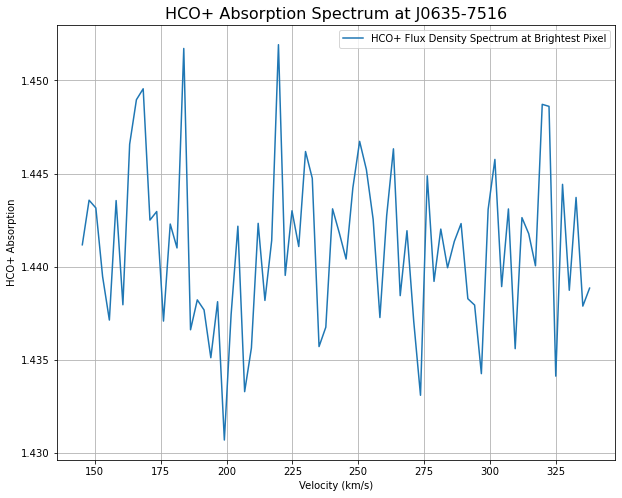

In [37]:
gass_hi(source = 'J0635-7516', molecule = 'HCOp')
#gass_hi(source = '2345-167', molecule = 'HCOp')
#gass_hi(source = 'J0049-4457', molecule = 'HCOp')
#gass_hi(source = '2355-534', molecule = 'HCOp')
#gass_hi(source = 'J0454-8101', molecule = 'HCOp')
#gass_hi(source = 'J1058-8003', molecule = 'HCOp')
#gass_hi(source = 'J2230+114', molecule = 'HCOp')

# Finding RMS

In [110]:
def rms(source = 'NGC7469'):
    
    #Open the cube (This is not the background source image, it is the acutal cube)
    #I am using the other file to find the brightest point in the background source and then plot the spectrum here.
    c_path = source + '_HCO.image.fits'
    c_cube = fits.open(c_path)
    c_data = c_cube[0].data
    c_header = c_cube[0].header
    
    c_squeezed_data = c_data[0, :, :, :]

    #Define the figure size
    #plt.figure(figsize=[10,8])

    #Define coordinate system in terms of RA and DEC for the cube
    c_ra_start = c_header["CRVAL1"]
    c_ra_inc = c_header["CDELT1"]

    c_channels = np.arange(c_header["NAXIS1"]) - c_header["CRPIX1"]+1

    c_ra = ra_start + (c_ra_inc * c_channels)
    c_ra = np.array(c_ra, dtype = float)

    c_dec_start = c_header["CRVAL2"]
    c_dec_inc = c_header["CDELT2"]

    c_channels1 = np.arange(c_header["NAXIS2"]) - c_header["CRPIX2"]+1

    c_dec = c_dec_start + (c_dec_inc * c_channels1)
    c_dec = np.array(c_dec, dtype = float)

    #Converting from Frequeny to Velocity
    c_frequency_start = c_header["CRVAL3"]
    c_frequency_inc = c_header["CDELT3"]

    c_channels2 = np.arange(c_header["NAXIS3"])

    c_frequency = c_frequency_start + (c_frequency_inc * c_channels2)
    #frequency = np.array(frequency, dtype = float)

    c_i_frequency = c_header["RESTFRQ"]
    c_velocity = (3E8*((c_i_frequency - c_frequency)/c_i_frequency))/1000
    c_velocity = np.array(c_velocity, dtype = float)
    print(c_velocity[0], c_velocity[-1])
    
    b_path = source + '.fits'
    b_cube = fits.open(b_path)
    b_data = b_cube[0].data
    b_header = b_cube[0].header
    print(b_data.shape)

    b_squeezed_data = b_data[0, 0, :, :]
    print(b_squeezed_data.shape)
    
    b_ra_start = b_header["CRVAL1"]
    b_ra_inc = b_header["CDELT1"]

    b_channels = np.arange(b_header["NAXIS1"]) - b_header["CRPIX1"]+1

    b_ra = ra_start + (b_ra_inc * b_channels)
    b_ra = np.array(b_ra, dtype = float)

    b_dec_start = b_header["CRVAL2"]
    b_dec_inc = b_header["CDELT2"]

    b_channels1 = np.arange(b_header["NAXIS2"]) - b_header["CRPIX2"]+1

    b_dec = b_dec_start + (b_dec_inc * b_channels1)
    b_dec = np.array(b_dec, dtype = float)
    
    #Looking through this, it might make more sense to define the box in terms of the pixel and then make a box of a certain
    #number of pixels on in either direction, rather than picking arbitrary points to define the edges of the box
    #I'm using a box of 15 pixels around the central coordinate so it is a square of 30 pixels on each side
    if source == 'NGC7714': 
        x1 = round(b_header["CRPIX1"]-(b_ra_start-354.058992)/b_ra_inc)-1
        y1 = round(b_header["CRPIX2"]-(b_dec_start-2.155161)/b_dec_inc)-1
    elif source == 'NGC7469':
        x1 = round(b_header["CRPIX1"]-(b_ra_start-345.815207)/b_ra_inc)-1
        y1 = round(b_header["CRPIX2"]-(b_dec_start-8.874053)/b_dec_inc)-1
    elif source == '2331p073':
        x1 = round(b_header["CRPIX1"]-(b_ra_start-353.553394)/b_ra_inc)-1
        y1 = round(b_header["CRPIX2"]-(b_dec_start-7.607653)/b_dec_inc)-1
    elif source == 'NGC3783':
        x1 = round(b_header["CRPIX1"]-(b_ra_start-174.757286)/b_ra_inc)-1
        y1 = round(b_header["CRPIX2"]-(b_dec_start+37.7385028)/b_dec_inc)-1
    elif source == '0208-512':
        x1 = round(b_header["CRPIX1"]-(b_ra_start-32.6925)/b_ra_inc)-1
        y1 = round(b_header["CRPIX2"]-(b_dec_start+51.01719444444)/b_dec_inc)-1
    elif source == 'J0635-7516':
        x1 = round(b_header["CRPIX1"]-(b_ra_start-98.943783)/b_ra_inc)-1
        y1 = round(b_header["CRPIX2"]-(b_dec_start+75.271337)/b_dec_inc)-1
    elif source == '2355-534':
        x1 = round(b_header["CRPIX1"]-(b_ra_start-359.471942)/b_ra_inc)-1
        y1 = round(b_header["CRPIX2"]-(b_dec_start+53.187136)/b_dec_inc)-1
    elif source == '2326-477':
        x1 = round(b_header["CRPIX1"]-(b_ra_start-352.323767)/b_ra_inc)-1
        y1 = round(b_header["CRPIX2"]-(b_dec_start+47.505308)/b_dec_inc)-1
    elif source == 'J1058-8003':
        x1 = round(b_header["CRPIX1"]-(b_ra_start-164.680290)/b_ra_inc)-1
        y1 = round(b_header["CRPIX2"]-(b_dec_start+80.065208)/b_dec_inc)-1
    elif source == 'J0454-8101':
        x1 = round(b_header["CRPIX1"]-(b_ra_start-72.522612)/b_ra_inc)-1
        y1 = round(b_header["CRPIX2"]-(b_dec_start+81.017342)/b_dec_inc)-1
    elif source == 'J0253-5441':
        x1 = round(b_header["CRPIX1"]-(b_ra_start-43.371585)/b_ra_inc)-1
        y1 = round(b_header["CRPIX2"]-(b_dec_start+54.69762111111)/b_dec_inc)-1
    elif source == '2345-167':
        x1 = round(b_header["CRPIX1"]-(b_ra_start-357.010867)/b_ra_inc)-1
        y1 = round(b_header["CRPIX2"]-(b_dec_start+16.520006)/b_dec_inc)-1
        
    box = 15
    
    print(x1)
    
    b_data_ra = b_squeezed_data[:, np.arange(x1-box, x1+box)]
    image = b_data_ra[np.arange(y1-box, y1+box), :]

    maxindex = np.unravel_index(image.argmax(), image.shape)
    
    spec_1_cont = image[maxindex]
    print(maxindex)
    
    points = np.where(image>0.99*np.nanmax(image))
    
    if maxindex[0] >= 14:
        x_val = x1 - (15 - maxindex[0])
    else:
        x_val = x1 + (15 - maxindex[0])
        
    if maxindex[1] >= 14:
        y_val = y1 - (15 - maxindex[1])
    else:
        y_val = y1 + (15 - maxindex[1])
    spectrum = c_squeezed_data[:, y_val, x_val]
    
    print(b_ra[x_val], b_dec[y_val])
    
    smoothing_15 = convolve(spectrum, Box1DKernel(15))
    smoothed_decimated_spect = smoothing_15[::15]
    spect = smoothed_decimated_spect[1:]
    decimated_xvals = c_velocity[::15]
    x = decimated_xvals[1:]
    
    squared = spect**2
    s_sum = np.sum(squared)
    sqrt = s_sum/len(spect)
    rms = math.sqrt(sqrt)
    print('RMS =', rms)
    
    plt.plot(c_velocity, spectrum, label = 'Spectrum at Brightest Pixel')
    print(np.sum(spectrum))
    
    plt.xlabel('Velocity (km/s)')
    #plt.ylabel('HCO+ Absorption')
    #plt.title('HCO+ Absorption Spectrum at '+ source, fontsize=16)
    #plt.legend()
    #plt.grid()    

-284.126696000035 -87.39059267140524
(1, 1, 224, 224)
(224, 224)
112
(15, 15)
338.1516991667 -16.52000611111
RMS = 0.005047461907048594
0.20242898


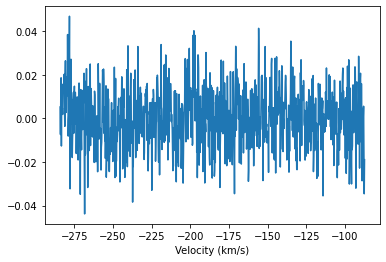

In [111]:
rms(source = '2345-167')

# Now finding Integrated Optical Depth

In [30]:
def integrated_optical_depth(source = 'NGC7469', molecule = 'HCOp'):
    
    #Start off by finding the continuum flux density
    path = source + '_' + molecule + '.pbcor.fits'
    cube = fits.open(path)
    data = cube[0].data
    header = cube[0].header
    
    squeezed_data = data[0, :, :, :]
    
    integrated = np.sum(squeezed_data[:, :, :], axis = 0)
    max_val = np.nanmax(integrated)
    x, y = np.where(integrated == np.nanmax(integrated))
    
    ra_start = header["CRVAL1"]
    ra_inc = header["CDELT1"]

    channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

    ra = ra_start + (ra_inc * channels)
    ra = np.array(ra, dtype = float)

    dec_start = header["CRVAL2"]
    dec_inc = header["CDELT2"]

    channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

    dec = dec_start + (dec_inc * channels1)
    dec = np.array(dec, dtype = float)
    
    #Converting from Frequeny to Velocity
    frequency_start = header["CRVAL3"]
    frequency_inc = header["CDELT3"]

    channels2 = np.arange(header["NAXIS3"])

    frequency = frequency_start + (frequency_inc * channels2)
    #frequency = np.array(frequency, dtype = float)

    i_frequency = header["RESTFRQ"]
    velocity = (3E8*(1 - (frequency/i_frequency)))/1000
    velocity = np.array(velocity, dtype = float)
    velocity_diff = velocity[1]- velocity[0]
    #print(velocity)
    
    #Defining the brightest pixels
    x1 = round(header["CRPIX1"]-(ra_start-float(ra[x]))/ra_inc)-1
    y1 = round(header["CRPIX2"]-(dec_start-float(dec[y]))/dec_inc)-1
    
    #Defining the brightest pixel for each point source based on previous findings
    if source == '2331p073':
        array = np.arange(700, 850, 1)
    elif source == 'J0635-7516':
        array = np.arange(800, 1050, 1)
    elif source == '2355-534':
        array = np.arange(850, 1000, 1)
    elif source == 'J1058-8003':
        array = np.arange(700, 825, 1)
    elif source == 'J0454-8101':
        array = np.arange(700, 850, 1)
    elif source == '2345-167':
        array = np.arange(0, 1900, 1)
    elif source == 'J2230+114':
        array = np.arange(1100, 1200, 1)
    elif source == 'J0049-4457':
        array = np.arange(700, 850, 1)
    
    data2 = squeezed_data[:, :, np.arange(x1-10, x1+10)]
    data3 = data2[:, np.arange(y1-10, y1+10), :]

    spectrum = squeezed_data[:, y1, x1]
        
    #print(data3.shape)

    decimated_xvals = (velocity[array])[::10]
    x = decimated_xvals[1:]
    
    entau = spectrum/np.mean(spectrum[0:100])
    #This is the e^-tau spectrum, so get tau first, then integrate
    
    print(np.mean(spectrum[0:100]))
    
    tau = -np.log(entau)
    
    import math
    
    array2 = np.arange(700, 1100, 1)
    std_dev1 = tau[array] - np.nanmean(tau[array2])
    std_dev2 = std_dev1**2
    std_dev3 = np.sum(std_dev2)
    std_dev4 = std_dev3/len(tau[array2])
    std_dev5 = math.sqrt(std_dev4)
    #print('Standard Deviation =', std_dev5)
    upper_limits = std_dev5*1.064*3*2*1.11e12
    #print(source, molecule, upper_limits/(1e11*1.064*2), np.nanmean(tau)*3)
    
    squared = [x**2 for x in array2]
    s_sum = np.sum(squared)
    sqrt = s_sum/len(array2)
    rms = math.sqrt(sqrt)
    rms = np.sqrt(np.mean(tau[array2]**2))
    print(source, molecule, 'RMS =', rms, 'Column Density = ', rms*1.064*3*2*1.11e12/1e11, 'Optical Depth = ', rms*3)

In [31]:
integrated_optical_depth(source = '2331p073', molecule = 'HCOp')
#integrated_optical_depth(source = '2331p073', molecule = 'HCN')
#integrated_optical_depth(source = '2331p073', molecule = 'HNC')
#integrated_optical_depth(source = '2331p073', molecule = 'CCH')

integrated_optical_depth(source = 'J0635-7516', molecule = 'HCOp')
#integrated_optical_depth(source = 'J0635-7516', molecule = 'HCN')
#integrated_optical_depth(source = 'J0635-7516', molecule = 'HNC')
#integrated_optical_depth(source = 'J0635-7516', molecule = 'CCH')

integrated_optical_depth(source = '2355-534', molecule = 'HCOp')
#integrated_optical_depth(source = '2355-534', molecule = 'HCN')
#integrated_optical_depth(source = '2355-534', molecule = 'HNC')
#integrated_optical_depth(source = '2355-534', molecule = 'CCH')

integrated_optical_depth(source = 'J1058-8003', molecule = 'HCOp')
#integrated_optical_depth(source = 'J1058-8003', molecule = 'HCN')
#integrated_optical_depth(source = 'J1058-8003', molecule = 'HNC')
#integrated_optical_depth(source = 'J1058-8003', molecule = 'CCH')

integrated_optical_depth(source = 'J0454-8101', molecule = 'HCOp')
#integrated_optical_depth(source = 'J0454-8101', molecule = 'HCN')
#integrated_optical_depth(source = 'J0454-8101', molecule = 'HNC')
#integrated_optical_depth(source = 'J0454-8101', molecule = 'CCH')

integrated_optical_depth(source = '2345-167', molecule = 'HCOp')
#integrated_optical_depth(source = '2345-167', molecule = 'HCN')
#integrated_optical_depth(source = '2345-167', molecule = 'HNC')
#integrated_optical_depth(source = '2345-167', molecule = 'CCH')

integrated_optical_depth(source = 'J2230+114', molecule = 'HCOp')
#integrated_optical_depth(source = 'J2230+114', molecule = 'HCN')
#integrated_optical_depth(source = 'J2230+114', molecule = 'HNC')
#integrated_optical_depth(source = 'J2230+114', molecule = 'CCH')

integrated_optical_depth(source = 'J0049-4457', molecule = 'HCOp')
#integrated_optical_depth(source = 'J0049-4457', molecule = 'HCN')
#integrated_optical_depth(source = 'J0049-4457', molecule = 'HNC')
#integrated_optical_depth(source = 'J0049-4457', molecule = 'CCH')

0.5311619
2331p073 HCOp RMS = 0.022618597 Column Density =  1.6028080945104364 Optical Depth =  0.06785579212009907
1.4418031
J0635-7516 HCOp RMS = 0.008145344 Column Density =  0.5771986561015249 Optical Depth =  0.024436033330857754
1.0688545
2355-534 HCOp RMS = 0.010140594 Column Density =  0.7185868349969388 Optical Depth =  0.030421782284975052
1.108368
J1058-8003 HCOp RMS = 0.017379986 Column Density =  1.231587528589368 Optical Depth =  0.05213995836675167
1.6235176
J0454-8101 HCOp RMS = 0.008603181 Column Density =  0.6096420361921191 Optical Depth =  0.025809542275965214
3.208116
2345-167 HCOp RMS = 0.005027278 Column Density =  0.35624497468248006 Optical Depth =  0.015081833582371473
3.0141625
J2230+114 HCOp RMS = 0.004051806 Column Density =  0.2871206932090223 Optical Depth =  0.012155417818576097
0.28777212
J0049-4457 HCOp RMS = 0.033975895 Column Density =  2.4076134968698026 Optical Depth =  0.10192768648266792


# Converting Galactic Coordinates to Magellanic Stream Coordinates

In [47]:
def hi_spectra(source = 'J0635-7516'):
    
    path = source + '_HCOp.pbcor.fits'
    cube = fits.open(path)
    data = cube[0].data
    header = cube[0].header
    
    squeezed_data = data[0, :, :, :]
    
    ra_start = header["CRVAL1"]
    ra_inc = header["CDELT1"]

    channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

    ra = ra_start + (ra_inc * channels)
    ra = np.array(ra, dtype = float)

    dec_start = header["CRVAL2"]
    dec_inc = header["CDELT2"]

    channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

    dec = dec_start + (dec_inc * channels1)
    dec = np.array(dec, dtype = float)

    if source == 'J0635-7516' or source == '2345-167' or source == 'J0454-8101' or source == 'J0049-4457' or source == 'J1058-8003' or source == '2355-534': 
        g_path = source + '_GASS_HI.fits'
        g_cube = fits.open(g_path)
        g_data = g_cube[0].data
        g_header = g_cube[0].header

        print(g_data.shape)

        g_ra_start = g_header["CRVAL1"]
        g_ra_inc = g_header["CDELT1"]

        g_channels = np.arange(g_header["NAXIS1"]) - g_header["CRPIX1"]+1

        g_ra = g_ra_start + (g_ra_inc * g_channels)
        g_ra = np.array(g_ra, dtype = float)

        g_dec_start = g_header["CRVAL2"]
        g_dec_inc = g_header["CDELT2"]

        g_channels1 = np.arange(g_header["NAXIS2"]) - g_header["CRPIX2"]+1

        g_dec = g_dec_start + (g_dec_inc * g_channels1)
        g_dec = np.array(g_dec, dtype = float)

        g_velocity_start = g_header["CRVAL3"]
        g_velocity_inc = g_header["CDELT3"]

        g_channels2 = np.arange(g_header["NAXIS3"])-g_header["CRPIX3"]+1

        g_velocity = g_velocity_start + (g_velocity_inc * g_channels2)
        g_velocity_kms = g_velocity/1000

        g_rng=range(len(g_velocity_kms))
        g_spectrum = []
        for i in g_rng:
            g_spectrum += [np.nansum(g_data[i,:,:])*g_velocity_inc]
            
        #print(g_spectrum[0, 1, 2, 3, 4])
            
        #if source == 'J0635-7516' or source == 'J0454-8101' or source == 'J0049-4457':
            #array = np.arange(500, 1093)
            #g_velocity_kms = g_velocity_kms[array]
            #g_spectrum = g_spectrum[array]

        plt.figure(figsize = [8, 6])
        plt.plot(g_velocity_kms, g_spectrum, label = 'GASS HI Data')

        plt.xlabel('Velocity (km/s)')
        plt.ylabel('HI Emisson')
        plt.title('GASS HI Emission at '+ source, fontsize=16)
        plt.legend()
        plt.grid()

    elif source == '2331p073' or source == 'J2230+114':
        if source == '2331p073':
            coord = '356.00+10.35'
        elif source == 'J2230+114':
            coord = '340.00+10.35'
        g_path = 'GALFA_HI_RA+DEC_' + coord + '_W.fits'
        g_cube = fits.open(g_path)
        g_data = g_cube[0].data
        g_header = g_cube[0].header

        print(g_data.shape)
        #print(g_header)

        g_ra_start = g_header["CRVAL1"]
        g_ra_inc = g_header["CDELT1"]

        g_channels = np.arange(g_header["NAXIS1"]) - g_header["CRPIX1"]+1

        g_ra = g_ra_start + (g_ra_inc * g_channels)
        g_ra = np.array(g_ra, dtype = float)

        g_dec_start = g_header["CRVAL2"]
        g_dec_inc = g_header["CDELT2"]

        g_channels1 = np.arange(g_header["NAXIS2"]) - g_header["CRPIX2"]+1

        g_dec = g_dec_start + (g_dec_inc * g_channels1)
        g_dec = np.array(g_dec, dtype = float)

        g_velocity_start = g_header["CRVAL3"]
        g_velocity_inc = g_header["CDELT3"]

        g_channels2 = np.arange(g_header["NAXIS3"])-g_header["CRPIX3"]+1

        g_velocity = g_velocity_start + (g_velocity_inc * g_channels2)
        g_velocity_kms = g_velocity/1000

        if source == '2331p073':
            x1 = round(header["CRPIX1"]-(ra_start-353.5534454167)/ra_inc)-1
            y1 = round(header["CRPIX2"]-(dec_start-7.60773555555577)/dec_inc)-1
        elif source == 'J2230+114':
            x1 = round(header["CRPIX1"]-(ra_start-338.1516991667)/ra_inc)-1
            y1 = round(header["CRPIX2"]-(dec_start-11.73081027778)/dec_inc)-1
        
        #Here we find the corresponding pixels for the brightest point in HCO+ in the GALFA data
        y_array = np.abs(g_dec-dec[y1])
        g_y = y_array.argmin()
        x_array = np.abs(g_ra-ra[x1])
        g_x = x_array.argmin()

        #I don't want to only take the spectra at those points, so we are going to make a box around it and that the spectra at each
        #of those points
        g_x1 = g_x - 10
        g_x2 = g_x + 10
        g_y1 = g_y - 10
        g_y2 = g_y + 10

        g_data2 = g_data[:, :, np.arange(g_x1, g_x2)]
        g_data3 = g_data2[:, np.arange(g_y1, g_y2), :]

        g_rng=range(len(g_velocity_kms))
        g_spectrum = []
        for i in g_rng:
            g_spectrum += [np.nansum(g_data3[i,:,:])*g_velocity_inc]

        plt.figure(figsize = [8, 6])
        plt.plot(g_velocity_kms, g_spectrum, label = 'GALFA HI Emission Spectrum')
        
        plt.xlabel('Velocity (km/s)')
        plt.ylabel('HI Emisson')
        plt.title('GALFA HI Emission at '+ source, fontsize=16)
        plt.legend()
        plt.grid()

(1093, 11, 11)
(1093, 11, 11)
(1093, 11, 11)
(1093, 11, 11)
(2048, 512, 512)
(2048, 512, 512)
(1093, 11, 11)
(1093, 11, 11)


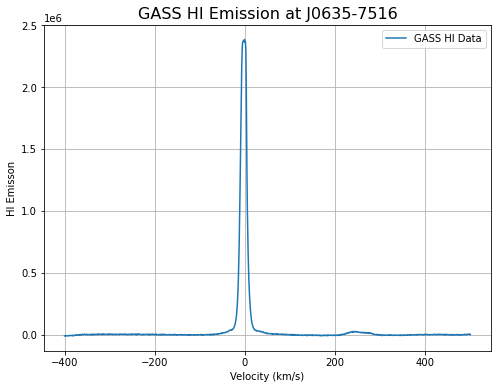

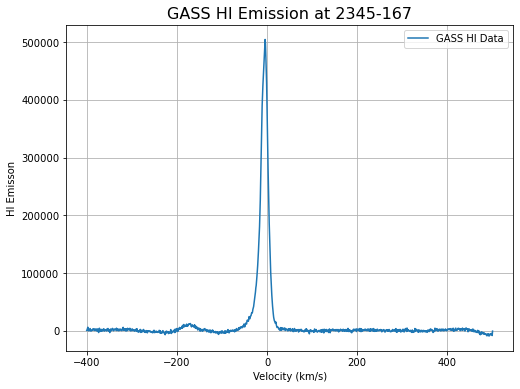

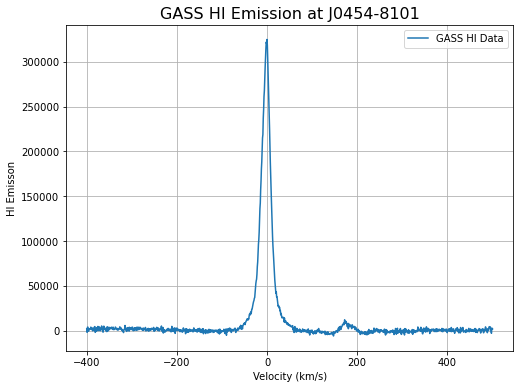

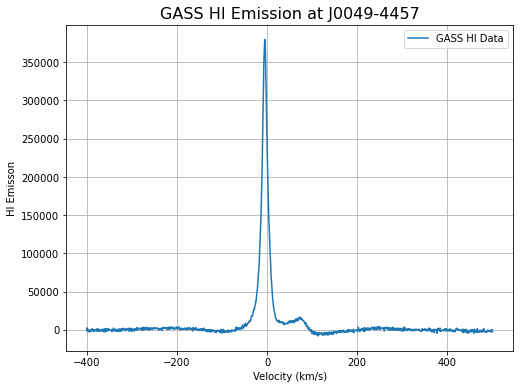

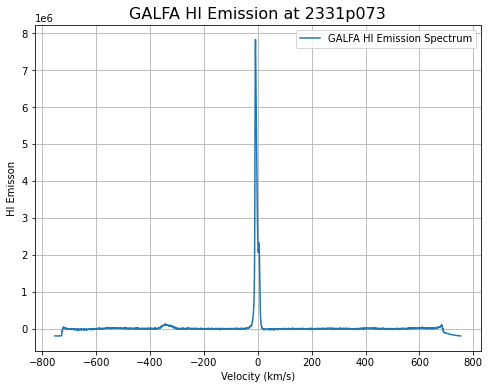

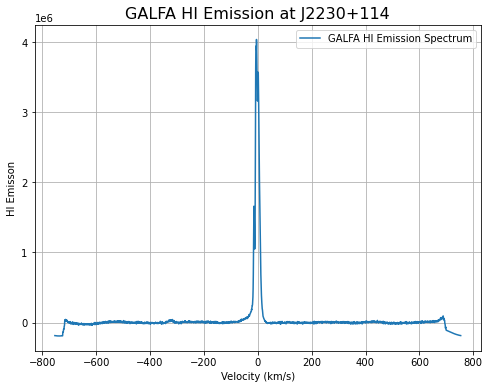

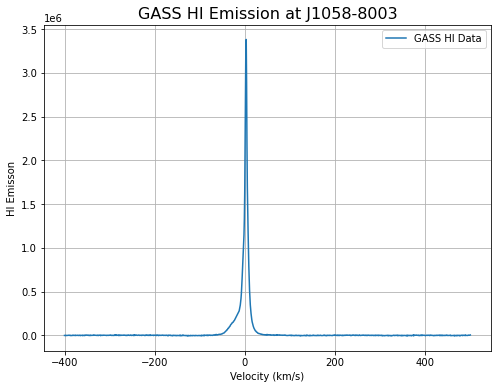

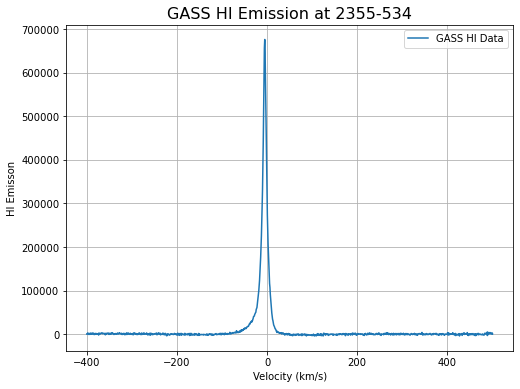

In [48]:
hi_spectra(source = 'J0635-7516')
hi_spectra(source = '2345-167')
hi_spectra(source = 'J0454-8101')
hi_spectra(source = 'J0049-4457')

hi_spectra(source = '2331p073')
hi_spectra(source = 'J2230+114')

hi_spectra(source = 'J1058-8003')
hi_spectra(source = '2355-534')